# Зачем нужны фильтры и почему Байесовы
## Начнем с фильтров, что они делают?
![](img/not-a-filter.png)

Речь не о фильтре в првычном смысле слова, т.е. о модуле который пропускает хорошие данные и выкидывает плохие  

![](img/noisy_measurements.jpg)

Задача фильтра - выделить полезный сигнал из шумного входа

## Хорошо, то такое "шумный вход"

### Например GPS
Даже в поле показания GPS будут отличаться от измерения к измерению

![](img/gnss_error_sources.jpg)

### Все еще хуже: мы не всегда можем измерять то что хотим знать


Как узнать едет ли вражеская машина
![](img/latent_velocity.jpeg)

## С чем нам приходится работать

* Мы не уверены в измерениях, но можем говорить о вероятности ошибки измерения ($z$)
* Мы не измеряем интересные вещи напрямую, т.е. работаем с латентными переменными ($x$)

$P(x \vert z) = \frac{P(z \vert x) P(x)}{P(z)}$


# Про фильтра Калмана

> Фи́льтр Ка́лмана — эффективный рекурсивный фильтр, оценивающий вектор состояния динамической системы, используя ряд неполных и зашумленных измерений. Назван в честь Рудольфа Калмана.

[Википедия](https://ru.wikipedia.org/wiki/Фильтр_Калмана)



## Какой еще системы

Динамической, т.е. мы знаем законы (хорошо когда *линейные*) по которым она развивается. Состояние системы мы описываем вектором состояния, а развивается она под действием вектора управления

![](img/dynamic.png)

Например если $x_{k}$ - положение машины (состояние) и $v_{k}$ ее скорость в момент времени $k$ (управление) то на момент времени $k+1$ машина будет находится в $x_{k+1} = x_{k} + \delta t \cdot v_k$, 

$\delta t$ разница времени между отсчетами


## Рекурсивный, что это

![](img/recursive.png)
Пусть мы знаем $x_{k-1}$ - оценку латентных переменных на момент времени $k-1$ 

1) Мы пронаблюдали  $z_{k-1}$

2) Используем эту оценку для уточнения $x_{k-1}$

3) Зная динамику системы предсказываем $x_k$ ждем нового измерения идем в первый пункт, рекурсия


В примере с машиной мы могли бы измерять ее позицию используя GPS, тогда разумно в качестве $x_k$ взять что-то средние между предсказанием $x_{k-1} + \delta t \cdot v_{k-1}$ и измерением $z_k$.

В этом и есть суть происходящего, математика объясняет почему это правильно и подбирает степень в которой надо верить предсказанию или измерению.


## Почему эффиктивный

При некоторых допущениях он дает оптимальную оценку вектора состояния

В качестве бонуса достатоно легко считается: все что нам потребуется - обращать матрицы небольшой размерности 

## Линейный Фильтр Калмана

См. детали [тут](http://www.probabilistic-robotics.org/)

### Состояние и управление

$x_k$ вектор состояня системы в момемнт времени $k$, считаем, что $x_k \sim N(\mu_k, \Sigma_k)$

$u_{k}$ вектор управление систмы в момент времени $k$ мы его дитктуем роботу или робот нам его сообщает, это не случайная переменная

Мы знаем динамику системы, т.е.

$\hat{x}_{k+1} = A_k \cdot x_{k-1} + B_k \cdot u_k + \epsilon_k$

Шляпа отличает предсказание от знаения, которое учитывает измерение в соответствующий момент времени

В том, что динамика системы линейна и состоит линейность фильтра

$\epsilon_k$ - шум, например моторы робота не в точности выполняют команды или вектор управления измеряется не точно. Мы считаем что $\epsilon_k \sim N(0, R_k)$

Т.е. 

$p(x_{k+1} \vert u_{k} x_{k}) \sim N(A_k \cdot x_k + B_k \cdot u_k, R_k)$

### Измерение

$z_k = C_k x_k + \delta_k$ - опять мы считаем то измерение линейно следует из состояния, но подвержено влиянию некоторого шума $\delta_k \sim N(0, Q_t)$

$p(z_k \vert x_k) \sim N(C_k x_k, Q_k)$

### Предсказание

$p(x_{k} \vert u_k) = \int p(x_{k} \vert u_{k} x_{k-1}) p(x_{k-1}) d x_k$

Произведение двух нормальных распределений $N(A_k \cdot x_k + B_k \cdot u_k, R_k)$ и $N(\mu_{k-1}, \Sigma_{k-1})$ заинтегрированное по $x_k$- нормальное распределение 

$N(B_k u_k + A_k \mu_{k-1}, A_k \Sigma_{k-1} A_k^T + R_k)) = N(\hat{\mu_k}, \hat{\Sigma_k})$

Тут некотрая математика, но интуитивно ясно - мы ожидаем увидеть робота там куда он поехал, при этом мы не знали где он был в начале (первый член дисперсии) и не знаем насколько точно н нас слушается (второй член дисперсии)

### Учет измерения

$p(x_k \vert z_k u_k) = \eta  p(z_k \vert x_k u_k) p(x_k \vert u_k)$ Формула Байеса.


Опять $N(C_k x_k, Q_k) N(\hat{\mu_k}, \hat{\Sigma_k})$ опять произведение нормальных распределений что же получим? 

Верно, снова нормальное распределение (в этот раз с [выводом](kalman-update-derivation.ipynb)),

$K_k = \hat{\Sigma_k} C_k^T (C_k \hat{\Sigma_k} C_k^T + Q_k)^-$

$\mu_k = \hat{\mu_k} +K_k (z_k - C_k \hat{\mu_k})$

$\Sigma_k = (I - K_k C_k) \hat{\Sigma_k}$

Такое $K_k$ является оптимальным если искать $\mu_k$ в виде линейной комбинации измерения и предсказания и пытаться минимизировать сумму квадратов отклонений $x_k$ от $\mu_k$ ([подробности](kalman-update-derivation.ipynb))

## Теперь все вместе

### Имеем

$x_{k-1}$ вектор состояния системы, случайная величина $x_{k-1} \sim N(\mu_k, \Sigma_k)$

В момент времени $k$ поступает измерение $z_k$ и управление $u_k$

Динамика системы и модель измерения считаются линейными:

$x_{k} = A_k x_{k-1} + B_k u_k + \epsilon_k$

$z_{k} = C_k x_k + \delta_k$

Шумы $\epsilon_k$ и $\delta_k$ являются случайными и распределены по нормальному закону

$\epsilon_k \sim N(0, R_k)$

$\delta_k \sim N(0, Q_k)$

#### 1) Предсказание 

$\hat{\mu_k} = B_k u_k + A_k \mu_{k-1}$ 

$\hat{\Sigma_k} = A_k \Sigma_{k-1} A_k^T + R_k$

#### 2) Обновление

$K_k = \hat{\Sigma_k} C_k^T (C_k \hat{\Sigma_k} C_k^T + Q_k)^-$

$\mu_k = \hat{\mu_k} +K_k (z_k - C_k \hat{\mu_k})$

$\Sigma_k = (I - K_k C_k) \hat{\Sigma_k}$

In [27]:
from robot import robot
from measurer import global_measurer

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from IPython import display
import time
from matplotlib.lines import Line2D
    
%matplotlib inline

In [2]:
class Kalman(object):
    """
    Simple kalman filter
    We use robot position as it's state and (noisy) observation of robot velocity as a control
    We assume that we can measure position directly, but with some noise
    """
    def __init__(self, measure_noise=1, control_noise=(0.1, 0.1)):
        # TODO: we don't know where robot is, how to say it using
        #       its position mu and sigma?
        self.position_mu = None
        self.position_sigma = None
        
        self.last_measure_time = 0
        
        self.measure_noise = measure_noise
        self.control_noise = control_noise
        
    def _A(self, t):
        # TODO state transition matrix
        #      our state is position, what is $x_{t+1}$ given $x_t$
        #      without control?
        pass
    
    def _B(self, t):
        dt = (t - self.last_measure_time)
        # TODO control transition matrix
        #      how control (velocity) $u$ affects our state if applied during time $dt$
        pass
    
    def _R(self, t):
        R = np.eye(2)
        
        # TODO
        # what is state transition noise, given that all uncertainty we have is
        # going from velocity measurement
        
        return R
    
    def _C(self, t):
        # TODO
        # what is our measurement (2x2) matrix (hint: we measure position directly)
        return None
    
    def _Q(self, t):
        # TODO what is uncertainty of our measurement
        return None
        
    def predict(self, robot_velocity, t):
        # TODO: implement, robot_velocity is a control vector here
        predicted_mu = None
        predicted_sigma = None
        
        self.position_mu = predicted_mu
        self.position_sigma = predicted_sigma
    
    def update(self, position, t):
        #TODO implement, position is a measurement here
        # prior to update we have called predict, thus we have predictions in state varaibles
        K_t = None
        
        self.position_mu = None
        self.position_sigma = None
        self.last_measure_time = t

In [9]:
def draw_position(position, covariance, color='black', ax=None):
    """
    Confidence ellipse of 3 sigma
    """
    lambda_, v = np.linalg.eig(covariance)
    lambda_ = np.sqrt(lambda_)
    
    if ax is None:
        ax = plt.subplot(111, aspect='equal')

    ell = Ellipse(xy=(position),
                  width=lambda_[0]*2, height=lambda_[1]*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])))
    
    ell.set_facecolor('none')
    ell.set_edgecolor(color)
    ax.add_artist(ell)
    
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    
    
    ax.scatter(position[0], position[1], c=color)
    return axaposterior

In [29]:
r = robot.Robot(pos=np.array((-7, 0)), vel=np.array((0.5, 0.1)), odometer_noise_x=0.5, odometer_noise_y=0.1)
m = global_measurer.GlobalMeasurer(noise=0.3)
k = Kalman(control_noise=(0.5, 0.1), measure_noise=0.3)

dt = 0.5
t = 0

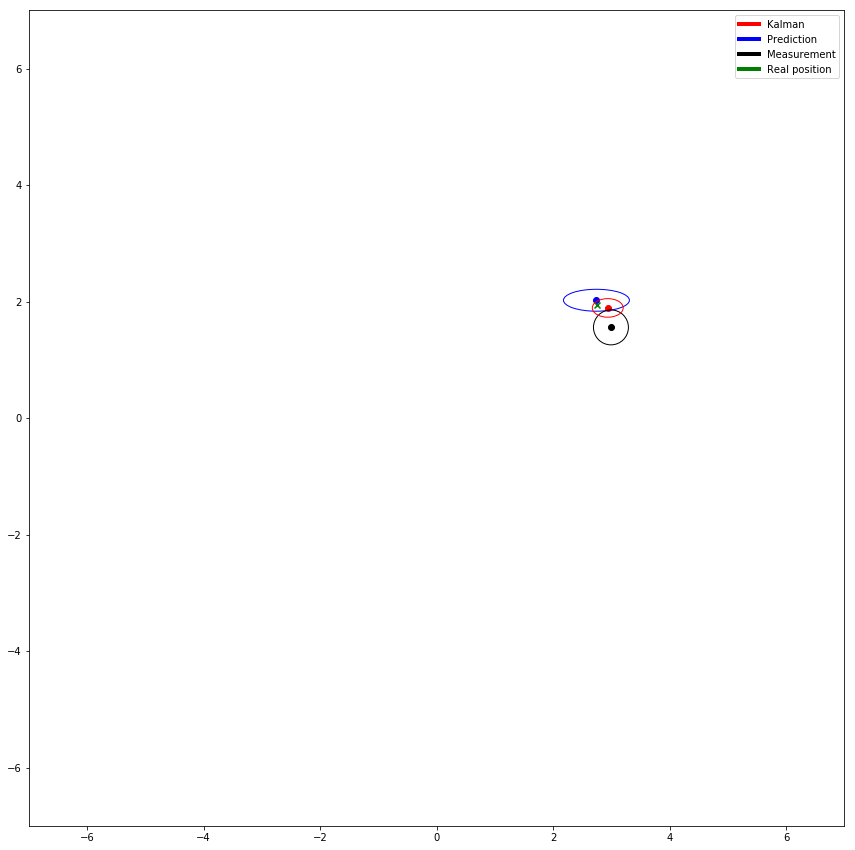

In [30]:

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111, aspect='equal')

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='green', lw=4)]


real_track = []
measured_track = []
kalman_track = []

# TODO
# Use kalman in a loop: 
# 1) use prior state to get prediction
# 2) get a measurement 
# 3) update kalman state

for i in range(40):
    ax.clear()
    
    ax.legend(custom_lines, ['Kalman', 'Prediction', 'Measurement', 'Real position'])
    
    # TODO make kalman prediction and draw it, using 'blue' color

    pos = m.measure(r)
    draw_position(pos, np.eye(2) * k.measure_noise**2, ax=ax)
    
    #TODO get kalman update and draw it with 'red'
    
    ax.scatter(r.state_[0], r.state_[1], marker='x', color='green')
    
    real_track.append((r.state_[0], r.state_[1]))
    measured_track.append(pos)
    kalman_track.append(k.position_mu)

    t += dt
    r.move(dt)
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

display.clear_output(wait=True)


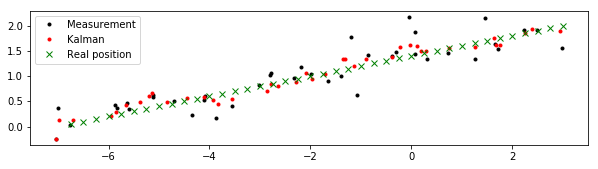

In [37]:
measured_track = np.array(measured_track)
real_track = np.array(real_track)
kalman_track = np.array(kalman_track)

plt.figure(figsize=(10, 10))
plt.subplot(111, aspect='equal')
plt.plot(measured_track[:, 0], measured_track[:, 1], '.', c="black", label='Measurement')
plt.plot(kalman_track[:, 0], kalman_track[:, 1], 'r.', label="Kalman")
plt.plot(real_track[:, 0], real_track[:, 1], 'gx', label="Real position")
plt.legend()